In [10]:
# show plots inline in the notebook
%matplotlib inline

from __future__ import division, print_function # python3 compatibilty

import numpy as np                  # import numpy
from time import time               # use for timing functions

# useful modules!
import sys
import os
import six

# make the plots look a bit nicer with some defaults
from matplotlib import pyplot as pl # import pyplot from matplotlib
import matplotlib as mpl
rcparams = {}
rcparams['text.usetex'] = True
rcparams['axes.linewidth'] = 0.5
rcparams['font.family'] = 'sans-serif'
rcparams['font.size'] = 22

# functions for plotting posteriors
import corner
from scipy.stats import gaussian_kde

In [11]:
# set the true values of the model parameters for creating the data
m = 3.5 # gradient of the line
c = 1.2 # y-intercept of the line

# set the "predictor variable"/abscissa
M = 100
xmin = 0.
xmax = 10.
stepsize = (xmax-xmin)/M
x = np.arange(xmin, xmax, stepsize)

# define the model function
def straight_line(x, m, c):
    """
    A straight line model: y = m*x + c
    
    Args:
        x (list): a set of abscissa points at which the model is defined
        m (float): the gradient of the line
        c (float): the y-intercept of the line
    """

    return m*x + c

# seed our random number generator, so we have reproducible data
np.random.seed(sum([ord(v) for v in 'samplers']))

# create the data - the model plus Gaussian noise
sigma = 0.5 # standard deviation of the noise
data = straight_line(x, m, c) + sigma*np.random.randn(M)


In [12]:
# import the Model class from CPNest
from cpnest.model import Model

LN2PI = np.log(2.*np.pi)

# set the model, likelihood and prior
class StraightLineModel(Model):
    """
    A simple straight line model, with a Gaussian likelihood.
    
    Args:
        data (:class:`numpy.ndarray`): an array containing the observed data
        abscissa (:class:`numpy.ndarray`): an array containing the points at which the data were taken
        modelfunc (function): a function defining the model
        sigma (float): the standard deviation of the noise in the data
        
    """
    names = ['m','c'] # parameter names (this is a required variables for the class)

    # define the boundaries using for initial sampling of the live points
    cmin = -10.  # lower range on c (the same as the uniform c prior lower bound)
    cmax = 10.   # upper range on c (the same as the uniform c prior upper bound)

    mmu = 0.     # mean of the Gaussian prior on m
    msigma = 10. # standard deviation of the Gaussian prior on m

    cbounds = [cmin, cmax]
    # set the m bounds to be +/- 10sigma about the mean
    mbounds = [mmu-10.*msigma, mmu+10.*msigma]

    # NOTE: the bounds could instead be set through arguments passed to the __init__
    # function for the class if wanted
    bounds=[mbounds, cbounds] # upper and lower bounds on each parameter (required for the class)

    def __init__(self, data, abscissa, modelfunc, sigma):
        # set the data
        self._data = data         # observed data
        self._abscissa = abscissa # points at which the observed data are taken
        self._sigma = sigma       # standard deviation(s) of the data
        self._logsigma = np.log(sigma) # log sigma here to save computations in the likelihood
        self._ndata = len(data)   # number of data points
        self._model = modelfunc   # model function

    def log_likelihood(self, params):
        """
        The natural logarithm of the likelihood function.

        Args:
            params (dict): a dictionary keyed to the parameter names.

        Returns:
            float: the log likelihood value.
        """
        # extract the parameters
        m = params['m']
        c = params['c']

        # calculate the model
        model = self._model(x, m, c)

        # normalisation
        norm = -0.5*self._ndata*LN2PI - self._ndata*self._logsigma

        # chi-squared
        chisq = np.sum(((self._data - model)/(self._sigma))**2)

        return norm - 0.5*chisq

    def log_prior(self,p):
        """
        The natural logarithm of the prior function.

        Args:
            p (dict): a dictionary keyed to parameter names.

        Returns:
            float: The log prior value.
        """
        # the uniform priors are dealt with by just checking that we're within the bounds
        if not self.in_bounds(p): return -np.inf # check parameters are all in bounds

        # Gaussian prior on m
        lp = 0.
        m = p['m']
        lp -= 0.5*((m-self.mmu)/self.msigma)**2 # no need for normalisation constant on the prior

        return lp

In [17]:
%%capture
# import cpnest
import cpnest

print('CPNest version: {}'.format(cpnest.__version__))

nlive = 1024      # number of live point
maxmcmc = 1024    # maximum MCMC chain length
nthreads = 4      # use one CPU core

# set up the algorithm
work = cpnest.CPNest(StraightLineModel(data, x, straight_line, sigma), verbose=0,
                     nthreads=nthreads, nlive=nlive, maxmcmc=maxmcmc);
# run the algorithm
t0 = time()
work.run();
t1 = time()

timecpnest = (t1-t0)

In [18]:
logZcpnest = work.NS.logZ                     # value of log Z
infogaincpnest = work.NS.state.info           # value of the information gain
logZerrcpnest = np.sqrt(infogaincpnest/nlive) # estimate of the statistcal uncertainty on logZ

# get the null log likelihood (evidence that the data is Gaussian noise with zero mean, and given standard devaition)
logZnull = work.user.log_likelihood({'m': 0., 'c': 0.})

print(six.u('log(Z) = {} \u00B1 {}'.format(logZcpnest, logZerrcpnest)))

# output the log Bayes factor
print('log Bayes factor is {}'.format(logZcpnest - logZnull))

log(Z) = -87.85199304778082 ± 0.10144704875071153
log Bayes factor is 89069.60916500207


In [19]:

# plot the resulting posteriors
mpl.rcParams.update({'font.size': 16})

#def plotposts(samples, truths=[m,c]):
def plotposts(samples, **kwargs):
    """
    Function to plot posteriors using corner.py and scipy's gaussian KDE function.
    """
    if "truths" not in kwargs:
        kwargs["truths"] = [m, c]
    
    fig = corner.corner(samples, labels=[r'$m$', r'$c$'], hist_kwargs={'density': True}, **kwargs)

    # plot KDE smoothed version of distributions
    for axidx, samps in zip([0, 3], samples.T):
        kde = gaussian_kde(samps)
        xvals = fig.axes[axidx].get_xlim()
        xvals = np.linspace(xvals[0], xvals[1], 100)
        fig.axes[axidx].plot(xvals, kde(xvals), color='firebrick')

Number of posterior samples is 2760


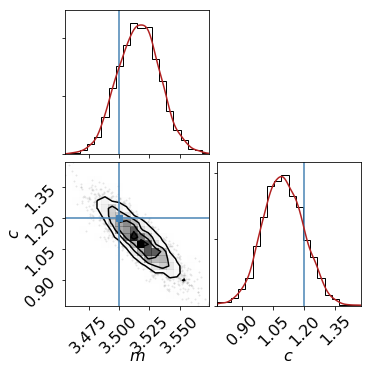

In [20]:

mchain_cpnest = work.posterior_samples['m'] # extract chain of m values
cchain_cpnest = work.posterior_samples['c'] # extract chain if c values
samples_cpnest = np.vstack((mchain_cpnest, cchain_cpnest)).T

# print out the number of posterior samples
print('Number of posterior samples is {}'.format(samples_cpnest.shape[0]))
resdict = {}

resdict['mcpnest_mu'] = np.mean(samples_cpnest[:,0])      # mean of m samples
resdict['mcpnest_sig'] = np.std(samples_cpnest[:,0])      # standard deviation of m samples
resdict['ccpnest_mu'] = np.mean(samples_cpnest[:,1])      # mean of c samples
resdict['ccpnest_sig'] = np.std(samples_cpnest[:,1])      # standard deviation of c samples
resdict['cccpnest'] = np.corrcoef(samples_cpnest.T)[0,1]  # correlation coefficient between parameters
resdict['cpnest_npos'] = len(samples_cpnest)              # number of posterior samples
resdict['cpnest_time'] = timecpnest                       # run time
resdict['cpnest_logZ'] = logZcpnest                       # log marginalised likelihood
resdict['cpnest_logZerr'] = logZerrcpnest                 # uncertainty on log(Z)

# plot using corner.py
plotposts(samples_cpnest)